In [3]:
# import the appropriate libraries
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [4]:
# load the CSV file taken from  https://www.kaggle.com/arjunbhasin2013/ccdata
df = pd.read_csv("CC GENERAL.csv")

# Data dictionary
https://www.kaggle.com/arjunbhasin2013/ccdata

<ul>
<li>CUST_ID : Identification of Credit Card holder (Categorical)</li>
<li>BALANCE : Balance amount left in their account to make purchases</li>
<li>BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)</li>
<li>PURCHASES : Amount of purchases made from account</li>
<li>ONEOFF_PURCHASES : Maximum purchase amount done in one-go</li>
<li>INSTALLMENTS_PURCHASES : Amount of purchase done in installment</li>
<li>CASH_ADVANCE : Cash in advance given by the user</li>
<li>PURCHASES_FREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)</li>
<li>ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)</li>
<li>PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)</li>
<li>CASHADVANCEFREQUENCY : How frequently the cash in advance being paid
<li>CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"</li>
<li>PURCHASES_TRX : Numbe of purchase transactions made</li>
<li>CREDIT_LIMIT : Limit of Credit Card for user</li>
<li>PAYMENTS : Amount of Payment done by user</li>
<li>MINIMUM_PAYMENTS : Minimum amount of payments made by user</li>
<li>PRCFULLPAYMENT : Percent of full payment paid by user</li>
<li>TENURE : Tenure of credit card service for user</li>
</ul>

In [5]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '_')
df = df.dropna()
df.columns
df

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8943,C19184,5.871712,0.500000,20.90,20.90,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,1,500.0,58.644883,43.473717,0.000000,6
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


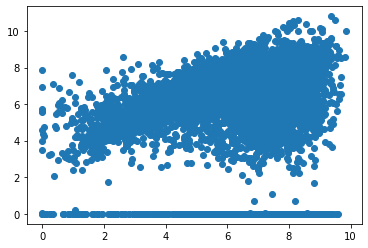

In [8]:
# let's explore the variables to see what might be interesting
# are there any variables that need to be transformed because
# they are not normally distributed?  (e.g. balance, purchases)
#df['balance'].plot.kde()
df['ln_balance'] = np.log(df['balance'] + 1)
#df['ln_balance'].plot.kde()
# df['purchases'].plot.kde()
df['ln_purchases'] = np.log(df['purchases'] + 1)
# df['ln_purchases'].plot.kde()
plt.scatter(df['ln_balance'], df['ln_purchases'])
plt.show()

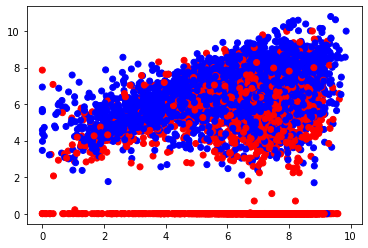

In [9]:
# change one of the variables to a binary variable to put
# the users into two buckets
# do a box plot of how these two buckets are different
df['paid_in_full'] = np.where(df['installments_purchases']==0, 1, 0)
# boxplot = df.boxplot(column=['purchases_frequency'], by='paid_in_full')
# plt.scatter(df['purchases_frequency'],df['tenure'])
col = np.where(df['paid_in_full'] ==1,'r',np.where(df['paid_in_full']==0,'b','r'))
plt.scatter(df['ln_balance'], df['ln_purchases'], c=col)
plt.show()

In [10]:
# we now want to take the full sample and build and test a model
# accordingly, we need to randomly take just 80% of the sample
# to help train the model and then have 20% of the sample for a
# testing sample; the way we will do this is to create a random variable
# in the full dataframe and then take 80% of the dataframe and put
# it into a training dataframe and put the remaining 20% of the full
# dataframe into a testing dataframe
df['mask'] = [np.random.uniform(0,1)  for k in df.index]
train = df[df['mask'] < 0.8]
test = df[df['mask']>= 0.8]
test

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,...,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,ln_balance,ln_purchases,paid_in_full,mask
10,C10011,1293.124939,1.000000,920.12,0.00,920.12,0.000000,1.000000,0.000000,1.000000,...,12,1200.0,1083.301007,2172.697765,0.000000,12,7.165590,6.825590,0,0.920368
13,C10014,921.693369,1.000000,2137.93,419.96,1717.97,0.000000,0.750000,0.166667,0.750000,...,26,7500.0,1655.891435,251.137986,0.083333,12,6.827297,7.668061,0,0.844528
15,C10016,6886.213231,1.000000,1611.70,0.00,1611.70,2301.491267,0.500000,0.000000,0.500000,...,11,8000.0,1993.439277,2109.906490,0.000000,12,8.837422,7.385665,0,0.920249
19,C10020,3577.970933,1.000000,398.64,0.00,398.64,0.000000,1.000000,0.000000,1.000000,...,12,4000.0,1053.980464,12465.549380,0.000000,12,8.182831,5.990564,0,0.831371
20,C10021,2016.684686,1.000000,176.68,0.00,176.68,0.000000,0.666667,0.000000,0.666667,...,8,2000.0,223.068600,13557.297260,0.000000,12,7.609706,5.179984,0,0.878074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8924,C19165,7.336804,0.333333,74.00,74.00,0.00,0.000000,0.166667,0.166667,0.000000,...,1,3000.0,214.921009,44.254787,0.000000,6,2.120680,4.317488,1,0.849612
8930,C19171,229.540018,1.000000,84.00,0.00,84.00,304.951421,1.000000,0.000000,0.833333,...,6,1000.0,124.373736,89.753056,0.000000,6,5.440424,4.442651,0,0.946406
8934,C19175,20.260716,0.833333,110.50,0.00,110.50,0.000000,0.666667,0.000000,0.500000,...,4,1500.0,161.476789,65.936751,0.500000,6,3.056861,4.714025,0,0.908039
8938,C19179,78.818407,0.500000,0.00,0.00,0.00,1113.186078,0.000000,0.000000,0.000000,...,0,1200.0,1397.770131,21.821194,0.333333,6,4.379754,0.000000,1,0.866518


In [11]:
# let's create a logistic regression trying to predict our dependent
# binary variable
YTrain = train[['paid_in_full']]
XTrain = train[['ln_balance', 'ln_purchases']]
LogisticModel = sm.Logit(YTrain, XTrain).fit()
print(LogisticModel.summary())

Optimization terminated successfully.
         Current function value: 0.449511
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           paid_in_full   No. Observations:                 6808
Model:                          Logit   Df Residuals:                     6806
Method:                           MLE   Df Model:                            1
Date:                Mon, 20 Apr 2020   Pseudo R-squ.:                  0.3436
Time:                        15:39:36   Log-Likelihood:                -3060.3
converged:                       True   LL-Null:                       -4661.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ln_balance       0.3903      0.012     33.026      0.000       0.367       0.414
ln_purchases    -0.5490

In [12]:
# we now use this model to help examine our testing set
YTest = test[['paid_in_full']]
XTest = test[['ln_balance', 'ln_purchases']]
YPred = LogisticModel.predict(XTest)
compare = pd.concat([YTest, YPred], axis=1)
compare = compare.rename(columns={0: 'prediction'})
compare['difference'] = compare['paid_in_full'] - compare['prediction']
compare.sort_values(by=['difference']) # similar to the examination of the residuals

,paid_in_full,prediction,difference
4682,0,0.938791,-0.938791
2742,0,0.881767,-0.881767
6642,0,0.804804,-0.804804
4850,0,0.793267,-0.793267
1000,0,0.775275,-0.775275
...,...,...,...
546,1,0.086871,0.913129
1263,1,0.086623,0.913377
8368,1,0.079687,0.920313
1351,1,0.075391,0.924609


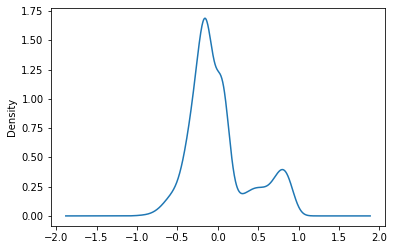

In [13]:
compare['difference'].plot.kde()

In [14]:
# Notice that by sorting the dataframe called 'compare' by the difference
# between the actual and the predicted value, we can see the false positives
# at the top and the false negatives at the bottom.
# Let's see if we can acutually compute the number of:
# true positives
# true negatives
# false positives
# false negatives
#
# we create a function to examine the difference between the
# predicted and actual

def rating(difference):
    if difference > 0.5:
        return "false negative"
    elif difference >= 0:
        return "true positive"
    elif difference >= -0.5:
        return "true negative"
    else:
        return "false positive"

In [15]:
# we then use this function to take a look at how well we do
compare['type'] = compare.apply(lambda x: rating(x['difference']),axis=1)
print("True positives: ", compare[compare['type'] == "true positive"].count()["type"])
print("True negatives: ", compare[compare['type'] == "true negative"].count()["type"])
print("False positives: ", compare[compare['type'] == "false positive"].count()["type"])
print("False negatives: ", compare[compare['type'] == "false negative"].count()["type"])

True positives:  516
True negatives:  976
False positives:  69
False negatives:  267


In [16]:
# we now move to looking at how a clustering approach might work
# let's use the same two dependent variables and try to create 4 clusters
dfc = df[['ln_balance','ln_purchases']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(dfc)
clusters = kmeans.cluster_centers_
clusters # shows the centroid of the clusters

array([[7.25955841, 5.413197  ],
       [7.12669916, 0.0218491 ],
       [7.0798064 , 7.6206846 ],
       [3.64407189, 5.79010504]])

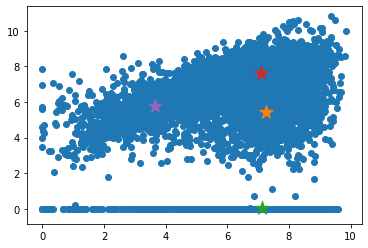

In [17]:
# now we can plot the data along with the centroids
# can you do better?
plt.scatter(dfc['ln_balance'],dfc['ln_purchases'])
plt.scatter(clusters[0][0],clusters[0][1], marker="*", s=200)
plt.scatter(clusters[1][0],clusters[1][1], marker="*", s=200)
plt.scatter(clusters[2][0],clusters[2][1], marker="*", s=200)
plt.scatter(clusters[3][0],clusters[3][1], marker="*", s=200)
plt.show()